In [ ]:
from HUTH_SemanticModel import SemanticSentenceModel
from matplotlib.pyplot import figure, cm
import numpy as np
import logging
import tqdm
from DataSequence import DataSequence
logging.basicConfig(level=logging.DEBUG)
from HUTH_stimulus_utils import load_grids_for_stories
from HUTH_stimulus_utils import load_generic_trfiles
from HUTH_stimulus_utils import load_simulated_trfiles
import nibabel as nib
from HUTH_dsutils import make_word_ds, make_phoneme_ds

from joblib import Parallel, delayed
from sklearn.linear_model import RidgeCV
import numpy as np
from os.path import join as opj
import os
from pytorch_lightning.callbacks import EarlyStopping
# import tables
import json
import matplotlib.pyplot as plt
import pickle
from os.path import join 
from scipy.stats import describe
from HUTH_npp import zscore
import h5py
import torch
from scipy.stats import pearsonr
from torch import nn
import wandb
from sklearn.preprocessing import StandardScaler

In [ ]:
LATENT_DIM = 4096

# sub="sub-03"
subjs  = ["S1", "S2", "S3"]
subjs_fullnames = [f"UTS0{i}" for i in range(1, 4)]
sub = "S1"

DATA_DIR = "/srv/nfs-data/sisko/storage/tutorial_language_fmri/semantic-decoding/data_train"
EM_DATA_DIR="/srv/nfs-data/sisko/storage/tutorial_language_fmri/deep-fMRI-dataset-master/em_data"


In [3]:
sessions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 20]
stories = []
with open(os.path.join(DATA_DIR, "sess_to_story.json"), "r") as f:
    sess_to_story = json.load(f) 
for sess in sessions:
    stories.extend(sess_to_story[str(sess)])

train_stories_len = 70

train_stories = stories[:train_stories_len]
test_stories = stories[train_stories_len:]+["wheretheressmoke"]

Rstories = train_stories
Pstories = test_stories
allstories = train_stories + test_stories 


# Load TextGrids

grids = load_grids_for_stories(stories,grid_dir=opj(DATA_DIR, "train_stimulus"))
test_grid = load_grids_for_stories(["wheretheressmoke"],grid_dir=opj(DATA_DIR.replace("train","test"), "test_stimulus","perceived_speech"))
grids.update(test_grid)


# Load TRfiles
# trfiles = load_generic_trfiles(allstories,grid_dir=opj(DATA_DIR, "ds003020/derivative/TextGrids"))
with open(join(DATA_DIR, "ds003020/derivative/respdict.json"), "r") as f:
    respdict = json.load(f)
trfiles = load_simulated_trfiles(respdict)
# Make word and phoneme datasequences
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

In [ ]:
encoding_results = {}
N= 10000
for sub in subjs:
    em_model_path = f"/srv/nfs-data/sisko/storage/tutorial_language_fmri/language_decoding/models/{sub}"
    
    # Load voxel correlations
    voxel_corrs = np.load(join(em_model_path, f"voxel_corrs_{sub}_llama_himalaya.npy"))
    
    # Get top N indices
    top_indices = np.argsort(voxel_corrs)[::-1][:N]
    
    # Describe the top voxel correlations
    description = describe(voxel_corrs.flatten()[top_indices])

    
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.hist(voxel_corrs, bins=100, label="all")
    axs.hist(voxel_corrs.flatten()[top_indices], bins=100, label="selected")
    axs.legend()
    axs.set_title(f"Voxel Correlations - LLama3-8B emebddings SUB: {sub}")

    
    # Store the results in the dictionary
    encoding_results[sub] = {
        "top_indices": top_indices,
        "description": description,
        "voxel_corrs": voxel_corrs
    }


In [5]:
tgt_dir=f"/srv/nfs-data/sisko/storage/tutorial_language_fmri/language_decoding/data_encoded/{sub}"
os.makedirs(tgt_dir,exist_ok=True)

with open(os.path.join(tgt_dir, 'semanticseqs.pkl'), 'rb') as f:
    semanticseqs = pickle.load(f)

with open(os.path.join(tgt_dir, 'sentences.pkl'), 'rb') as f:
    sentences = pickle.load(f)

print(f'Dictionaries have been loaded from {tgt_dir}')


## load also heldout 

with open(os.path.join(tgt_dir, 'semanticseqs_heldout.pkl'), 'rb') as f:
    semanticseqs_heldout = pickle.load(f)

with open(os.path.join(tgt_dir, 'sentences_heldout.pkl'), 'rb') as f:
    sentences_heldout = pickle.load(f)

print(f'Dictionaries have been loaded from {tgt_dir}')

semanticseqs.update(semanticseqs_heldout)
sentences.update(sentences_heldout)

Dictionaries have been loaded from /srv/nfs-data/sisko/storage/tutorial_language_fmri/language_decoding/data_encoded/S3
Dictionaries have been loaded from /srv/nfs-data/sisko/storage/tutorial_language_fmri/language_decoding/data_encoded/S3


## Load and downsample stimuli

In [6]:
def make_delayed(stim, delays, circpad=False):
    """Creates non-interpolated concatenated delayed versions of [stim] with the given [delays] 
    (in samples).
    
    If [circpad], instead of being padded with zeros, [stim] will be circularly shifted.
    """
    nt,ndim = stim.shape
    dstims = []
    for di,d in enumerate(delays):
        dstim = np.zeros((nt, ndim))
        if d<0: ## negative delay
            dstim[:d,:] = stim[-d:,:]
            if circpad:
                dstim[d:,:] = stim[:-d,:]
        elif d>0:
            dstim[d:,:] = stim[:-d,:]
            if circpad:
                dstim[:d,:] = stim[-d:,:]
        else: ## d==0
            dstim = stim.copy()
        dstims.append(dstim)
    return np.hstack(dstims)

def get_response(stories, subject, ):
	"""Get the subject"s fMRI response for stories."""
	subject_dir = join(DATA_DIR, "train_response/%s" % subject)
	
	# main_path = pathlib.Path(__file__).parent.parent.resolve()

	# base = os.path.join(main_path, subject_dir)
	resp = []
	for story in stories:
		resp_path = os.path.join(subject_dir, "%s.hf5" % story)
		hf = h5py.File(resp_path, "r")
		resp.extend(hf["data"][:])
		hf.close()
	return np.array(resp)

def get_val_response(stories, subject):
    """Get the subject"s fMRI response for stories."""

    subject_dir = opj(DATA_DIR.replace("train","test"),  "test_response",subject,"perceived_speech")

    resp = []
    for story in stories:
        resp_path = os.path.join(subject_dir, "%s.hf5" % story)
        hf = h5py.File(resp_path, "r")
        resp.extend(hf["data"][:])
        hf.close()
    return np.array(resp)

def create_word_mapping(wordseq, window_size=4, context_size=5):
    data = wordseq.data
    data_times = wordseq.data_times    
    tr_times = wordseq.tr_times
    word_mapping = {}

    for tr in tr_times:
        # Find the indices of the TR times that fall within the window
        window_indices = [i for i, t in enumerate(tr_times) if t <= tr][-window_size:]
        
        if not window_indices:
            continue
        
        # Find the corresponding data times for the window
        window_start = tr_times[window_indices[0]]
        window_end = tr_times[window_indices[-1]]

        # Include words within the window
        words_in_window = [word for word, time in zip(data, data_times) if window_start <= time <= window_end]
        
        # Include context words before the window
        context_start = window_start - context_size
        context_words = [word for word, time in zip(data, data_times) if context_start <= time < window_start][-context_size:]
        
        # Combine context words and words in window
        combined_words = context_words + words_in_window
        
        word_mapping[tr] = " ".join(combined_words).strip()

    return list(word_mapping.values())


In [7]:
# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in tqdm.tqdm(allstories):
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)


print("Stack stimuli")

# Combine stimuli
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])

# Print the sizes of these matrices
print ("Rstim shape: ", Rstim.shape)
print ("Pstim shape: ", Pstim.shape)

def make_delayed(stim, delays, circpad=False,stack=False):
    """Creates non-interpolated concatenated delayed versions of [stim] with the given [delays] 
    (in samples).
    
    If [circpad], instead of being padded with zeros, [stim] will be circularly shifted.
    """
    nt,ndim = stim.shape
    dstims = []
    for di,d in enumerate(delays):
        dstim = np.zeros((nt, ndim))
        if d<0: ## negative delay
            dstim[:d,:] = stim[-d:,:]
            if circpad:
                dstim[d:,:] = stim[:-d,:]
        elif d>0:
            dstim[d:,:] = stim[:-d,:]
            if circpad:
                dstim[:d,:] = stim[-d:,:]
        else: ## d==0
            dstim = stim.copy()
        dstims.append(dstim)
    if stack:
        return np.hstack(dstims)
    else:
        return np.array(dstims)


    # Delay stimuli
ndelays = 4
delays = range(1, ndelays+1)

print ("FIR model delays: ", delays)

delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)

  2%|▏         | 2/83 [00:00<00:04, 16.59it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


  7%|▋         | 6/83 [00:00<00:04, 17.58it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 12%|█▏        | 10/83 [00:00<00:04, 15.99it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 17%|█▋        | 14/83 [00:00<00:04, 15.67it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 23%|██▎       | 19/83 [00:01<00:03, 17.77it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 28%|██▊       | 23/83 [00:01<00:03, 17.35it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 33%|███▎      | 27/83 [00:01<00:03, 17.08it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 37%|███▋      | 31/83 [00:01<00:02, 17.89it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 43%|████▎     | 36/83 [00:02<00:02, 20.59it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 47%|████▋     | 39/83 [00:02<00:02, 20.44it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 54%|█████▍    | 45/83 [00:02<00:01, 19.95it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 58%|█████▊    | 48/83 [00:02<00:01, 19.99it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 65%|██████▌   | 54/83 [00:02<00:01, 21.80it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 69%|██████▊   | 57/83 [00:03<00:01, 20.10it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 76%|███████▌  | 63/83 [00:03<00:00, 21.00it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 83%|████████▎ | 69/83 [00:03<00:00, 20.08it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 87%|████████▋ | 72/83 [00:03<00:00, 21.83it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


 94%|█████████▍| 78/83 [00:04<00:00, 20.54it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


100%|██████████| 83/83 [00:04<00:00, 19.38it/s]

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
Stack stimuli


Rstim shape:  (23850, 4096)
Pstim shape:  (3890, 4096)
FIR model delays:  range(1, 5)


In [8]:
Rsentences_dict = dict()
for story in Rstories:
    Rsentences_dict[story] = create_word_mapping(wordseqs[story])[10:-5]

Psentences_dict = dict()
for story in Pstories:
    Psentences_dict[story] = create_word_mapping(wordseqs[story])[10:-5]

Rsentences = [sentence for story in Rstories for sentence in Rsentences_dict[story]]
Psentences = [sentence for story in Pstories for sentence in Psentences_dict[story]]

## Load responses

In [ ]:
responses={}
responses_all={}

for sub in subjs:
    responses[sub]={"train": [], "test":[]}
    for story in tqdm.tqdm(train_stories):
        responses[sub]["train"].append(get_response([story],sub))

    for story in test_stories:
        if story == "wheretheressmoke":
            responses[sub]["test"].append(get_val_response([story],sub))
        else:
            responses[sub]["test"].append(get_response([story],sub))

    zRresp = np.concatenate(responses[sub]["train"])
    zPresp = np.concatenate(responses[sub]["test"])

    ## add to the responses_all dictionary
    responses_all[sub] = {"train": zRresp, "test": zPresp}
    

In [ ]:
print('zRresp shape: ', responses_all['S1']['train'].shape)       # total voxels
print('zPresp shape: ', responses_all['S1']['test'].shape)
print ("delRstim shape: ", delRstim.shape)                        # total words delayed
print ("delPstim shape: ", delPstim.shape)

zRresp shape:  (23850, 81126)
zPresp shape:  (3890, 81126)
delRstim shape:  (4, 23850, 4096)
delPstim shape:  (4, 3890, 4096)


In [ ]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, fmri_data, data, labels, subjects_ids):
        self.fmri_data = fmri_data
        self.data = data
        self.labels = labels
        self.subjects_ids = subjects_ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fmri = self.fmri_data[idx]
        embs = self.data[idx]
        labels = self.labels[idx]
        sub = self.subjects_ids[idx]
        return fmri, embs, labels, sub
        # return {"fmri_data": self.data[idx], "labels": self.labels[idx]}

In [20]:
train_datasets = []
test_datasets = []

subject_id = 1
for sub in responses_all:
    zRresp = responses_all[sub]["train"]
    zPresp = responses_all[sub]["test"]
    top_indices = encoding_results[sub]["top_indices"]
    
    # Create subject ID lists
    train_subject_ids = [subject_id] * len(zRresp)
    test_subject_ids = [subject_id] * len(zPresp)
    
    # Create train and test datasets
    train_dataset = SimpleDataset(
        torch.tensor(zRresp[:, top_indices]).float(),
        torch.tensor(delRstim).float().permute(1, 0, 2),
        Rsentences,
        train_subject_ids
    )
    
    test_dataset = SimpleDataset(
        torch.tensor(zPresp[:, top_indices]).float(),
        torch.tensor(delPstim).float().permute(1, 0, 2),
        Psentences,
        test_subject_ids
    )
    
    # Append to the lists
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)
    
    # Increment subject ID
    subject_id += 1

# Concatenate all train and test datasets
train_dataset_all = torch.utils.data.ConcatDataset(train_datasets)
test_dataset_all = torch.utils.data.ConcatDataset(test_datasets)

## Start from Here

In [9]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, fmri_data, data, labels, subjects_ids):
        self.fmri_data = fmri_data
        self.data = data
        self.labels = labels
        self.subjects_ids = subjects_ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fmri = self.fmri_data[idx]
        embs = self.data[idx]
        labels = self.labels[idx]
        sub = self.subjects_ids[idx]
        return fmri, embs, labels, sub
        # return {"fmri_data": self.data[idx], "labels": self.labels[idx]}

In [ ]:
train_dataset_all = torch.load("*")
test_dataset_all = torch.load("*")

In [11]:
sample = train_dataset_all[1200]
input_tensor = sample[0]
target_tensor = sample[1]
sentence = sample[2]
subject_id = sample[3]

print("Input tensor shape: ", input_tensor.shape)
print("Target tensor shape: ", target_tensor.shape)
print("Sentence: ", sentence)
print("Subject ID: ", subject_id)

Input tensor shape:  torch.Size([10000])
Target tensor shape:  torch.Size([4, 4096])
Sentence:  very fine woman um brilliant a and beautiful we're partnered in raising her we're not partnered romantically
Subject ID:  1


In [12]:
BS = 1024

train_loader = torch.utils.data.DataLoader(train_dataset_all, batch_size=BS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_all, batch_size=BS, shuffle=False)

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim,act_fn=nn.Identity,alignment_layers_keys=[1,2,3],common_dim=4096):
        super(Encoder, self).__init__()
        self.common_dim=common_dim
        self.alignment_layers={}
        for k in alignment_layers_keys:
            self.alignment_layers[k]=nn.LazyLinear(common_dim)
        
        layers = []
        prev_dim = input_dim
        layers.append(nn.LayerNorm(common_dim))
        if len(hidden_dims):
            
            for hidden_dim in hidden_dims:
                layers.append(nn.LazyLinear(hidden_dim))
                layers.append(act_fn())
                prev_dim = hidden_dim
            
            # another layer norm
            layers.append(nn.LazyLinear(output_dim))
            # layers.append(nn.LayerNorm(output_dim))
             
        else:
            layers.append(nn.Linear(common_dim, output_dim))
        self.net = nn.Sequential(*layers)    

        
    def _apply(self, fn):
        super(Encoder, self)._apply(fn)        
        for k,v in self.alignment_layers.items():
            self.alignment_layers[k]._apply(fn)
            
    
    def forward(self, x, k=None):
        
        def apply_alignment_layers(x, k, alignment_layers):
            # Create an empty tensor to store the results
            result = torch.empty_like(x)
            result = result[:,:self.common_dim]
            
            # Iterate through each unique key in k
            for key in k.unique():
                # Create a mask for all elements that match the current key
                mask = (k == key.item())
                
                # print(x.shape, result.shape, mask)
                
                # Apply the corresponding alignment layer to the masked elements
                result[mask] = alignment_layers[key.item()](x[mask])
            
            return result
        
        if k is None:
            k=torch.ones(len(x))
        # Apply alignment layers to x using the custom function
        x = apply_alignment_layers(x, k, self.alignment_layers)
        
        # x = self.alignment_layers[k](x)
        return self.net(x)

In [14]:
class EmbeddingPooler(torch.nn.Module):
    def __init__(self, input_dim=4096,hidden_dims=[1024,512], latent_dim=1024, act_fn=nn.GELU):
        super(EmbeddingPooler, self).__init__()

        ## create an MLP
        layers = []
        prev_dim = input_dim
        if len(hidden_dims):
            
            layers.append(nn.LayerNorm(input_dim))
            for hidden_dim in hidden_dims:
                layers.append(nn.LazyLinear(hidden_dim))
                layers.append(act_fn())
            
            #another layer norm
            layers.append(nn.LazyLinear(latent_dim//4))
            layers.append(nn.LayerNorm(latent_dim//4))
            
        self.net = nn.Sequential(*layers)

        # self.fc = nn.LazyLinear(latent_dim)
    
    def forward(self, embeddings):
        # embeddings shape: (batch_size, 4, 4096)
        
        embeddings_proj = self.net(embeddings)

        #reshape
        pooled_embeddings = embeddings_proj.view(len(embeddings), -1)

        # Average pooling
        # pooled_embeddings = torch.mean(embeddings, dim=1)  # shape: (batch_size, 4096)
        
        # Project to common space
        # embeddings_proj = self.fc(pooled_embeddings)  # shape: (batch_size, latent_dim)
        
        return pooled_embeddings

In [15]:
act_fn = nn.Identity
common_dim = 10000
hidden_dims = [2048]
latent_dim = LATENT_DIM

lr = 1e-3     
blur = 25
tau = 0.05    
wd = 1e-4    



In [ ]:
import pytorch_lightning as pl
import torch.nn.functional as F

# Funzione per calcolare la similarità coseno
def cosine_similarity_matrix(A, B):
    A_norm = F.normalize(A, dim=1)
    B_norm = F.normalize(B, dim=1)
    return torch.mm(A_norm, B_norm.T)

# NT-Xent Loss (Contrastive)
def contrastive_loss_nt(S, tau):
    S_exp = torch.exp(S / tau)
    loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
    return loss.mean()

def contrastive_loss(z_i, z_j, tau):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    logits = (z_i @ z_j.T) / tau
    similarities = z_j @ z_j.T
    # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)
    targets = torch.arange(logits.shape[0]).long().to(logits.device)
    loss = torch.nn.functional.cross_entropy(logits, targets)
    return loss


class ContrastiveOTModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims, output_dim, common_dim=1024, alignment_layers_keys=[1,2,5,7], act_fn=nn.Identity, tau=0.2, lr=1e-3, wd=1e-4, loss_weights=(1, 1)):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dims, output_dim, act_fn=act_fn, alignment_layers_keys=alignment_layers_keys, common_dim=common_dim)
        self.pooler = EmbeddingPooler(latent_dim=output_dim, act_fn=act_fn)
        self.tau = tau
        self.lr = lr
        self.wd = wd
        self.loss_weights = loss_weights

        self.train_losses = []
        self.train_contrastive_loss=[]
        self.val_losses = []
        self.val_contrastive_loss=[]
    
        self.train_history={}
        self.val_history={}

        self.train_history["train_loss"]=[]
        self.train_history["train_contrastive_loss"]=[]
        self.val_history["val_loss"]=[]
        self.val_history["val_contrastive_loss"]=[]

    def forward(self, x, embeddings = None, **kwargs):
        fmri_proj = self.encoder(x, **kwargs)
        if embeddings is not None:
            embeddings_proj = self.pooler(embeddings)
            return fmri_proj, embeddings_proj
        return fmri_proj
        

    def loss_fn(self, x_latent, y_latent):
        S = cosine_similarity_matrix(x_latent, y_latent)
        contrastive_loss_value = contrastive_loss_nt(S, self.tau) 
        total_loss = self.loss_weights[1]*contrastive_loss_value
        return total_loss, contrastive_loss_value
    
    def compute_loss(self, x, embeddings, idx):
        x_latent, y_latent = self(x, embeddings, k=idx)
        return self.loss_fn(x_latent, y_latent)

    def training_step(self, batch, batch_idx):
        x, embeddings, sent, idx = batch
        loss, contrastive_loss_value = self.compute_loss(x, embeddings, idx)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_contrastive_loss", contrastive_loss_value, on_epoch=True)

        self.train_losses.append(loss.item())
        self.train_contrastive_loss.append(contrastive_loss_value.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, embeddings, sent, idx = batch
        loss, contrastive_loss_value = self.compute_loss(x, embeddings, idx)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_contrastive_loss", contrastive_loss_value, on_epoch=True)

        self.val_losses.append(loss.item())
        self.val_contrastive_loss.append(contrastive_loss_value.item())
        return loss
    
    def on_train_epoch_end(self) -> None:
        self.train_history["train_loss"].append(np.mean(self.train_losses))
        self.train_history["train_contrastive_loss"].append(np.mean(self.train_contrastive_loss))
        self.train_losses = []
        self.train_contrastive_loss=[]
        return super().on_train_epoch_end()
    
    def on_validation_epoch_end(self) -> None:
        self.val_history["val_loss"].append(np.mean(self.val_losses))
        self.val_history["val_contrastive_loss"].append(np.mean(self.val_contrastive_loss))
        self.val_losses = []
        self.val_contrastive_loss=[]
        return super().on_validation_epoch_end()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, threshold=0.05, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
brain_model = ContrastiveOTModel(input_dim=10000,
                                hidden_dims=hidden_dims,
                                output_dim=latent_dim,
                                common_dim=common_dim, 
                                alignment_layers_keys=[1,2,3],
                                act_fn=act_fn,
                                tau=tau,
                                lr=lr,
                                wd=wd)

In [ ]:
pl.seed_everything(55, workers=True)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.08, patience=7, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=25, devices=[1], callbacks=[early_stop_callback])

# trainer = pl.Trainer(max_epochs=15, devices=[1])
trainer.fit(brain_model, train_loader, test_loader)

In [ ]:
plt.plot(brain_model.train_history["train_loss"], label='train')
plt.plot(brain_model.val_history["val_loss"], label='val')

## Save Models

In [ ]:
tgt_dir = "*"

clone_model = ContrastiveOTModel(input_dim=10000,
                                hidden_dims=hidden_dims,
                                output_dim=latent_dim,
                                common_dim=common_dim, 
                                alignment_layers_keys=[1,2,3],
                                act_fn=act_fn,
                                blur=blur,
                                tau=tau,
                                lr=lr,
                                wd=wd)

state_dict = torch.load(f"{tgt_dir}/whole_model_state_dict.pt")
encoder_state_dict = torch.load(f"{tgt_dir}/encoder_state_dict.pt")
pooler_state_dict = torch.load(f"{tgt_dir}/pooler_state_dict.pt")
clone_model.load_state_dict(state_dict)
clone_model.encoder.load_state_dict(encoder_state_dict)
clone_model.pooler.load_state_dict(pooler_state_dict)

for k in clone_model.encoder.alignment_layers.keys():
        alignment_layer_state_dict = torch.load(f"{tgt_dir}/alignment_layers_{k}_state_dict.pt")
        clone_model.encoder.alignment_layers[k].load_state_dict(alignment_layer_state_dict)


In [22]:
from collections import defaultdict

# Initialize the dictionary to store results for each subject
results = defaultdict(lambda: {"y_pred": [], "y_gt": [], "gt_sentences": []})

# Assuming test_loader is defined and provides batches of (x, y, s, k)
with torch.no_grad():
    for x, y, s, k in tqdm.tqdm(test_loader):
        y_hat_fmri, y_hat_embeddings = brain_model(x, y, k=k)
        for subject_index in torch.unique(k):
            mask = k == subject_index
            results[subject_index.item()]["y_pred"].append(y_hat_fmri[mask])
            results[subject_index.item()]["y_gt"].append(y_hat_embeddings[mask])
            results[subject_index.item()]["gt_sentences"].extend(np.array(s)[mask].tolist())

# Concatenate the results for each subject
for subject_index in results:
    results[subject_index]["y_pred"] = torch.cat(results[subject_index]["y_pred"], dim=0)
    results[subject_index]["y_gt"] = torch.cat(results[subject_index]["y_gt"], dim=0)

100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


In [23]:
def compute_normalized_similarities(y_pred, y_gt):
    # Normalize by L2 norm
    y_pred_norm = torch.nn.functional.normalize(y_pred, dim=1)
    y_gt_norm = torch.nn.functional.normalize(y_gt, dim=1)

    # Compute similarity
    sims = y_pred_norm @ y_gt_norm.T

    # Normalize similarities
    scaler = StandardScaler()
    sims_z = scaler.fit_transform(sims.cpu().numpy())

    return sims, sims_z

In [24]:
similarities = {}

for subject_index in results:
    y_pred = results[subject_index]["y_pred"]
    y_gt = results[subject_index]["y_gt"]

    sims, sims_z = compute_normalized_similarities(y_pred, y_gt)
    
    similarities[subject_index] = {
        "similarities": sims,
        "normalized_similarities": sims_z,
        "gt_sentences": results[subject_index]["gt_sentences"]
    }

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x72d9164987d0>


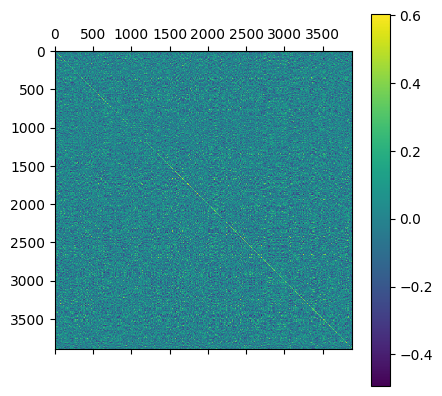

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

cos = cosine_similarity(y_pred, y_gt)
plt.matshow(sims)
plt.colorbar()

In [26]:
(sims_z.argmax(1)==np.arange(len(sims_z))).sum()/len(sims_z)

0.13856041131105398

## Only Test Story similarities

In [48]:
Pstories

['myfathershands',
 'theadvancedbeginner',
 'firetestforlove',
 'theshower',
 'birthofanation',
 'listo',
 'thecurse',
 'thetriangleshirtwaistconnection',
 'mayorofthefreaks',
 'cautioneating',
 'theinterview',
 'jugglingandjesus',
 'wheretheressmoke']

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x72d81183fe90>


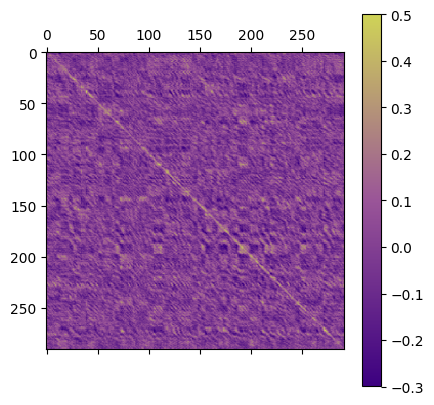

In [49]:
from matplotlib.colors import LinearSegmentedColormap

story_indices = {}
tot_index= 0
sub_idx = 3

neuroposter_cmap = LinearSegmentedColormap.from_list('Neuroposter', (
    # Edit this gradient at https://eltos.github.io/gradient/#Neuroposter=3C0080-9A5598-CFD357
    (0.000, (0.235, 0.000, 0.502)),
    (0.500, (0.604, 0.333, 0.596)),
    (1.000, (0.812, 0.827, 0.341))))

for i, story in enumerate(Pstories):
    start_index = tot_index
    end_index = start_index + wordseqs[story].tr_times[10:-5].shape[0]
    story_indices[story] = (start_index, end_index)
    tot_index = end_index

story = Pstories[-1]
start_index, end_index = story_indices[story]

slice_len = end_index - start_index
mean_sims = []
y_pred_story = []
y_true_story = []
for sub_i in range(3):
    sims = similarities[sub_i+1]["similarities"]
    y_pred_ = results[sub_i+1]["y_pred"]
    y_true_ = results[sub_i+1]["y_gt"]
    sims_slice_ = sims[start_index:end_index, start_index:end_index]
    y_pred_slice = y_pred_[start_index:end_index]
    y_true_slice = y_true_[start_index:end_index]
    mean_sims.append(sims_slice_)
    y_pred_story.append(y_pred_slice)
    y_true_story.append(y_true_slice)

mean_sims = np.stack(mean_sims, axis=0).mean(axis=0)
mean_ypred = np.stack(y_pred_story, axis=0).mean(axis=0)
mean_ytrue = np.stack(y_true_story, axis=0).mean(axis=0)

sims = similarities[sub_idx]["similarities"]
sims_slice = sims[start_index:end_index, start_index:end_index]

plt.matshow(mean_sims, vmin=-0.3, vmax=0.5, cmap=neuroposter_cmap)
plt.colorbar()

In [50]:
diagonal_values_otcl = np.diag(mean_sims)
off_diagonal_values_otcl = mean_sims[~np.eye(mean_sims.shape[0], dtype=bool)]

mean_diag_otcl = diagonal_values_otcl.mean()
std_diag_otcl  = diagonal_values_otcl.std()
mean_off_otcl  = off_diagonal_values_otcl.mean()
std_off_otcl   = off_diagonal_values_otcl.std()

print("\nStatistiche Diagonale:")
print(f"Media  = {mean_diag_otcl:.4f}")
print(f"Dev Std= {std_diag_otcl:.4f}")

print("\nStatistiche Fuori Diagonale:")
print(f"Media  = {mean_off_otcl:.4f}")
print(f"Dev Std= {std_off_otcl:.4f}")


Statistiche Diagonale:
Media  = 0.2294
Dev Std= 0.0818

Statistiche Fuori Diagonale:
Media  = 0.0004
Dev Std= 0.0827


## Real top-1 --> Only Test Story

In [30]:
story_indices = {}
tot_index= 0
for i, story in enumerate(Pstories):
    start_index = tot_index
    end_index = start_index + wordseqs[story].tr_times[10:-5].shape[0]
    story_indices[story] = (start_index, end_index)
    tot_index = end_index


N = 10  # Number of closest sentences to find

closest_sentences_per_story_all = {}

for sub_idx in [1,2,3]:
        
    # Dictionary to store closest sentences for each story
    closest_sentences_per_story = {}

    # Iterate over each story
    for story in Pstories:
        start_index, end_index = story_indices[story]
        
        #find the right similarity matrix
        sims = similarities[sub_idx]["similarities"]
        
        # Extract the relevant slices for the current story
        sims_slice = sims[start_index:end_index, start_index:end_index]
        Psentences_slice = Psentences[start_index:end_index]
        
        closest_sentences_per_story[story] = []
        # Find the closest N sentences for each prediction in the current story
        closest_sentences = []
        for idx in range(sims_slice.shape[0]):
            # Get the indices of the top N closest elements in the current slice
            closest_indices = torch.topk(sims_slice[idx], N).indices.cpu().numpy()
            
            # Retrieve the corresponding sentences from the current slice
            closest_sentences = [Psentences_slice[i] for i in closest_indices]
        
            # Store the closest sentences for the current story
            closest_sentences_per_story[story].append({"target":Psentences_slice[idx] , "retrieved": closest_sentences})

    closest_sentences_per_story_all[sub_idx] = closest_sentences_per_story

In [31]:
import pandas as pd

dataframes_all={}
for sub_idx in [1,2,3]:
    dataframes = {}
    for story, data in closest_sentences_per_story_all[sub_idx].items():
        columns = ["Target Sentence"] + [f"Retrieved Sentence {i+1}" for i in range(N)]
        rows = []
        for entry in data:
            row = [entry["target"]] + entry["retrieved"]
            rows.append(row)
        
        df = pd.DataFrame(rows, columns=columns)
        dataframes[story] = df
        # print(df.head())  # Print the first few rows for inspection
    dataframes_all[sub_idx]=dataframes

In [32]:
def word_overlap(sentence1, sentence2):
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    overlap = words1.intersection(words2)
    total_words = len(words1.union(words2))
    return len(overlap) / total_words if total_words > 0 else 0

def calculate_accuracies(df, threshold=0.5):
    top1_count = 0
    top10_count = 0
    total = len(df)
    
    for index, row in df.iterrows():
        target_sentence = row['Target Sentence']
        retrieved_sentences = row[1:].tolist()
        
        # Calculate word overlap ratios
        overlaps = [word_overlap(target_sentence, retrieved_sentence) for retrieved_sentence in retrieved_sentences]
        
        # Check for top-1 accuracy
        if overlaps[0] >= threshold:
            top1_count += 1
        
        # Check for top-10 accuracy (all retrieved sentences)
        if any(overlap >= threshold for overlap in overlaps[:10]):
            top10_count += 1
    
    top1_accuracy = top1_count / total
    top10_accuracy = top10_count / total
    
    return top1_accuracy, top10_accuracy

In [ ]:
print(calculate_accuracies(dataframes_all[1]["wheretheressmoke"]))
print(calculate_accuracies(dataframes_all[2]["wheretheressmoke"]))
print(calculate_accuracies(dataframes_all[3]["wheretheressmoke"]))


(0.36769759450171824, 0.7903780068728522)
(0.3127147766323024, 0.7250859106529209)
(0.5085910652920962, 0.8247422680412371)


In [51]:
dataframes_all[1][story]['Target Sentence']

0      my seatbelt and when his foot hit the brake at...
1      brake at the red light i flung open the door a...
2      flung open the door and i ran i had no shoes o...
3      door and i ran i had no shoes on i was crying ...
4      shoes on i was crying i had no wallet but i wa...
                             ...                        
286    they can be and what friends and comfort and k...
287    friends and comfort and kinship they can bring...
288    and kinship they can bring it took me a long t...
289    took me a long time to quit that boyfriend and...
290    long time to quit that boyfriend and then to q...
Name: Target Sentence, Length: 291, dtype: object

In [52]:
mean_ypred.shape, mean_ytrue.shape

((291, 4096), (291, 4096))

## Linear Baseline

In [113]:
inputs = []
targets = []
subject_ids = []

inputs_test = []
targets_test = []
sentence_test = []
subject_ids_test = []

for sample in train_dataset_all:
    inputs.append(sample[0].numpy())  # (10000,)
    targets.append(sample[1].numpy().reshape(-1))  # (16384,)
    subject_ids.append(sample[3])  # es. 'sub-01'

inputs = np.stack(inputs)        
targets = np.stack(targets)      
subject_ids = np.array(subject_ids)

unique_subjects = np.unique(subject_ids)

for sample in test_dataset_all:
    inputs_test.append(sample[0].numpy())  
    targets_test.append(sample[1].numpy())  
    sentence_test.append(sample[2])  
    subject_ids_test.append(sample[3])  

inputs_test = np.stack(inputs_test)        
targets_test = np.stack(targets_test) 
sentence_test = np.stack(sentence_test)      
subject_ids_test = np.array(subject_ids_test)

In [114]:
inputs.shape, targets.shape, subject_ids.shape

((71550, 10000), (71550, 16384), (71550,))

In [115]:
inputs_test.shape, targets_test.shape, subject_ids_test.shape, sentence_test.shape

((11670, 10000), (11670, 4, 4096), (11670,), (11670,))

In [43]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend

subject_idx = 3
mask = subject_ids == subject_idx
mask_test = subject_ids_test == subject_idx

device_id = 1  
torch.cuda.set_device(device_id)
backend = set_backend("torch_cuda")
X_subject = backend.asarray(inputs[mask]).to(f'cuda:{device_id}')     
Y_subject = backend.asarray(targets[mask]).to(f'cuda:{device_id}')  
X_test_subject = backend.asarray(inputs_test[mask_test]).to(f'cuda:{device_id}')     

model = RidgeCV(alphas=[0.1,1,20,1e2,1e3,1e4], fit_intercept=True)
model.fit(X_subject, Y_subject)

Y_pred = model.predict(X_test_subject)        
Y_pred_reshaped = Y_pred.reshape(-1, 4, 4096) 

print("Predicted shape:", Y_pred_reshaped.shape)


Predicted shape: torch.Size([3890, 4, 4096])


In [36]:
from collections import defaultdict

results_linear = defaultdict(lambda: {"y_pred": [], "y_gt": [], "gt_sentences": []})

In [44]:
results_linear[subject_idx]["y_pred"] = np.array(Y_pred_reshaped)
results_linear[subject_idx]["y_gt"] = targets_test[mask_test]
results_linear[subject_idx]["gt_sentences"] = sentence_test[mask_test].tolist()

In [ ]:
import pickle

with open("*", "rb") as f:
    results_linear_baseline = pickle.load(f)


In [151]:
results_linear_baseline[2]["y_pred"].shape, results_linear_baseline[3]["y_pred"].shape, results_linear_baseline[1]["y_pred"].shape

((3890, 4, 4096), (3890, 4, 4096), (3890, 4, 4096))

In [152]:
results_linear_baseline[2]["y_gt"].shape, results_linear_baseline[3]["y_gt"].shape, results_linear_baseline[1]["y_gt"].shape

((3890, 4, 4096), (3890, 4, 4096), (3890, 4, 4096))

In [153]:
similarities_baseline = {}

for subject_index in results_linear_baseline:
    y_pred = results_linear_baseline[subject_index]["y_pred"]
    y_gt = results_linear_baseline[subject_index]["y_gt"]

    sims_baseline, sims_z_baseline = compute_normalized_similarities(torch.tensor(y_pred).mean(dim=1), torch.tensor(y_gt).mean(dim=1))
    
    similarities_baseline[subject_index] = {
        "similarities": sims_baseline,
        "normalized_similarities": sims_z_baseline,
        "gt_sentences": results_linear_baseline[subject_index]["gt_sentences"]
    }

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7429f7c52ca0>


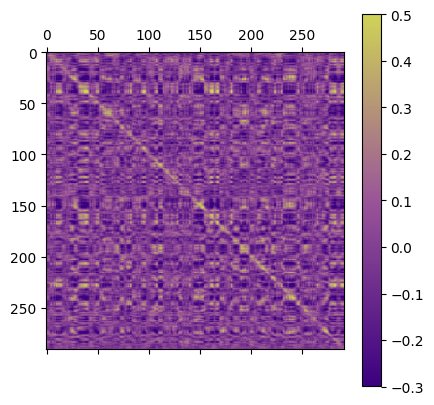

In [154]:
mean_sims_base = []
for sub_i in range(3):
    sims = similarities_baseline[sub_i+1]["similarities"]
    sims_slice_ = sims[start_index:end_index, start_index:end_index]
    mean_sims_base.append(sims_slice_)
mean_sims_base = np.stack(mean_sims_base, axis=0).mean(axis=0)

plt.matshow(mean_sims_base, vmin=-0.3, vmax=0.5, cmap=neuroposter_cmap)
plt.colorbar()

In [155]:
diagonal_values_otcl = np.diag(mean_sims_base)
off_diagonal_values_otcl = mean_sims_base[~np.eye(mean_sims_base.shape[0], dtype=bool)]

mean_diag_otcl = diagonal_values_otcl.mean()
std_diag_otcl  = diagonal_values_otcl.std()
mean_off_otcl  = off_diagonal_values_otcl.mean()
std_off_otcl   = off_diagonal_values_otcl.std()

print("\nStatistiche Diagonale:")
print(f"Media  = {mean_diag_otcl:.4f}")
print(f"Dev Std= {std_diag_otcl:.4f}")

print("\nStatistiche Fuori Diagonale:")
print(f"Media  = {mean_off_otcl:.4f}")
print(f"Dev Std= {std_off_otcl:.4f}")


Statistiche Diagonale:
Media  = 0.2394
Dev Std= 0.1124

Statistiche Fuori Diagonale:
Media  = -0.0010
Dev Std= 0.1187


In [157]:
import pandas as pd

story_indices = {}
tot_index= 0
for i, story in enumerate(Pstories):
    start_index = tot_index
    end_index = start_index + wordseqs[story].tr_times[10:-5].shape[0]
    story_indices[story] = (start_index, end_index)
    tot_index = end_index


N = 10  # Number of closest sentences to find

closest_sentences_per_story_all = {}

for sub_idx in [1,2,3]:
        
    # Dictionary to store closest sentences for each story
    closest_sentences_per_story = {}

    # Iterate over each story
    for story in Pstories:
        start_index, end_index = story_indices[story]
        
        #find the right similarity matrix
        sims_baseline = similarities_baseline[sub_idx]["similarities"]
        
        # Extract the relevant slices for the current story
        sims_slice_baseline = sims_baseline[start_index:end_index, start_index:end_index]
        Psentences_slice = Psentences[start_index:end_index]
        
        closest_sentences_per_story[story] = []
        # Find the closest N sentences for each prediction in the current story
        closest_sentences = []
        for idx in range(sims_slice_baseline.shape[0]):
            # Get the indices of the top N closest elements in the current slice
            closest_indices = torch.topk(sims_slice_baseline[idx], N).indices.cpu().numpy()
            
            # Retrieve the corresponding sentences from the current slice
            closest_sentences = [Psentences_slice[i] for i in closest_indices]
        
            # Store the closest sentences for the current story
            closest_sentences_per_story[story].append({"target":Psentences_slice[idx] , "retrieved": closest_sentences})

    closest_sentences_per_story_all[sub_idx] = closest_sentences_per_story


dataframes_all={}
for sub_idx in [1,2,3]:
    dataframes = {}
    for story, data in closest_sentences_per_story_all[sub_idx].items():
        columns = ["Target Sentence"] + [f"Retrieved Sentence {i+1}" for i in range(N)]
        rows = []
        for entry in data:
            row = [entry["target"]] + entry["retrieved"]
            rows.append(row)
        
        df = pd.DataFrame(rows, columns=columns)
        dataframes[story] = df
        # print(df.head())  # Print the first few rows for inspection
    dataframes_all[sub_idx]=dataframes

In [158]:
def word_overlap(sentence1, sentence2):
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    overlap = words1.intersection(words2)
    total_words = len(words1.union(words2))
    return len(overlap) / total_words if total_words > 0 else 0

def calculate_accuracies(df, threshold=0.5):
    top1_count = 0
    top10_count = 0
    total = len(df)
    
    for index, row in df.iterrows():
        target_sentence = row['Target Sentence']
        retrieved_sentences = row[1:].tolist()
        
        # Calculate word overlap ratios
        overlaps = [word_overlap(target_sentence, retrieved_sentence) for retrieved_sentence in retrieved_sentences]
        
        # Check for top-1 accuracy
        if overlaps[0] >= threshold:
            top1_count += 1
        
        # Check for top-10 accuracy (all retrieved sentences)
        if any(overlap >= threshold for overlap in overlaps[:10]):
            top10_count += 1
    
    top1_accuracy = top1_count / total
    top10_accuracy = top10_count / total
    
    return top1_accuracy, top10_accuracy

In [159]:
print(calculate_accuracies(dataframes_all[1]["wheretheressmoke"]))
print(calculate_accuracies(dataframes_all[2]["wheretheressmoke"]))
print(calculate_accuracies(dataframes_all[3]["wheretheressmoke"]))

(0.23367697594501718, 0.5532646048109966)
(0.27147766323024053, 0.5876288659793815)
(0.38144329896907214, 0.7079037800687286)


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x742914149040>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7429aa6dd580>


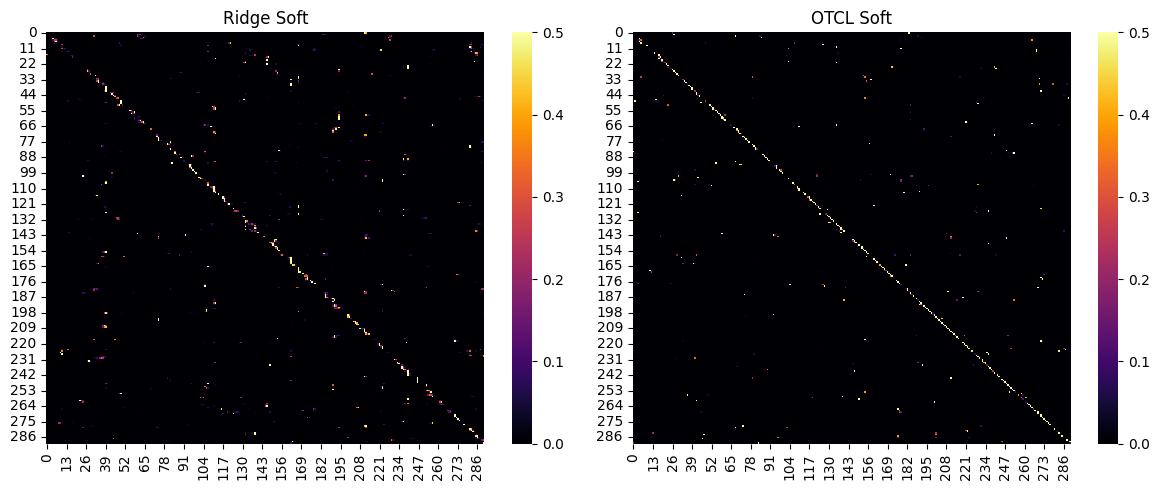

In [160]:
import torch
import torch.nn.functional as F
import seaborn as sns

cmap = 'inferno'

sims_otcl_soft = F.softmax(torch.tensor(mean_sims)/0.01, dim=1)
sims_ridge_soft = F.softmax(torch.tensor(mean_sims_base)/0.01, dim=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

sns.heatmap(sims_ridge_soft, cmap=cmap, vmin=0, vmax=0.5, ax=axes[0])
axes[0].set_title("Ridge Soft")
sns.heatmap(sims_otcl_soft, cmap=cmap, vmin=0, vmax=0.5, ax=axes[1])
axes[1].set_title("OTCL Soft")

plt.tight_layout()
plt.show()

## Comparing

In [193]:
start_index, end_index

(3599, 3890)

In [194]:
feat_ridge_list = []
feat_otcl_list = []
feat_true_list = []

for subject_index in results_linear_baseline:
    y_pred_baseline = results_linear_baseline[subject_index]["y_pred"]
    feat_ridge_list.append(y_pred_baseline)

for subject_index in results:
    y_pred_ot = results[subject_index]["y_pred"]
    feat_otcl_list.append(y_pred_ot)
    y_gt = results[subject_index]["y_gt"]
    feat_true_list.append(y_gt)


feat_ridge_subj = np.stack(feat_ridge_list, axis=0).mean(axis=0)[start_index:end_index].mean(axis=1)
feat_true_subj = np.stack(feat_true_list, axis=0).mean(axis=0)[start_index:end_index]
feat_otcl_subj = np.stack(feat_otcl_list, axis=0).mean(axis=0)[start_index:end_index]

In [195]:
feat_otcl_subj.shape, feat_true_subj.shape, feat_ridge_subj.shape

((291, 4096), (291, 4096), (291, 4096))

In [ ]:
# np.save("*", feat_otcl_subj)
y_pred_mlp = np.load("*/y_pred_mlp.npy")

Paired t-test: t = 96.32016127265653, p = 0.0
Cohen's d: 1.505


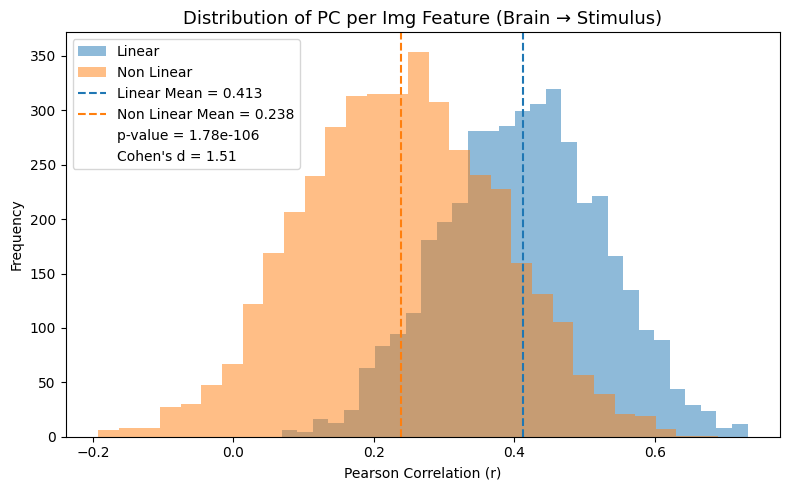

In [205]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D

y_true = feat_true_subj
y_pred_linear = feat_otcl_subj
y_pred_mlp = y_pred_mlp

def get_corrs(y_true, y_pred):
    return [np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(y_true.shape[1])]

corr_linear = get_corrs(y_true, y_pred_linear)
corr_mlp = get_corrs(y_true, y_pred_mlp)

mean_linear = np.mean(corr_linear)
mean_mlp = np.mean(corr_mlp)

t_stat, p_val = ttest_rel(corr_linear, corr_mlp, alternative='greater')
print(f"Paired t-test: t = {t_stat}, p = {p_val}")

diff = np.array(corr_linear) - np.array(corr_mlp)
cohens_d = diff.mean() / diff.std()
print(f"Cohen's d: {cohens_d:.3f}")

plt.figure(figsize=(8, 5))
plt.hist(corr_linear, bins=30, alpha=0.5, label='Linear', color='tab:blue')
plt.hist(corr_mlp, bins=30, alpha=0.5, label='Non Linear', color='tab:orange')
plt.axvline(mean_linear, color='tab:blue', linestyle='--', label=f'Linear Mean = {mean_linear:.3f}')
plt.axvline(mean_mlp, color='tab:orange', linestyle='--', label=f'Non Linear Mean = {mean_mlp:.3f}')

plt.title("Distribution of PC per Img Feature (Brain → Stimulus)", fontsize=13)
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("Frequency")

stat_legend = [
    Line2D([0], [0], color='none', label=f'p-value = {1.78e-106}'),
    Line2D([0], [0], color='none', label=f"Cohen's d = {cohens_d:.2f}")
]

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + stat_legend, labels + [h.get_label() for h in stat_legend])

plt.grid(False)
plt.tight_layout()
plt.show()

In [201]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(corr_linear, corr_mlp, alternative='greater')
print(f"Paired t-test: t = {t_stat}, p = {p_val}")

diff = np.array(corr_linear) - np.array(corr_mlp)
cohens_d = diff.mean() / diff.std()
print(f"Cohen's d: {cohens_d:.3f}")

Paired t-test: t = 96.32016127265653, p = 0.0
Cohen's d: 1.505
